In [2]:
from __future__ import division

In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('paper')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
from joblib import Memory
memory = Memory(cachedir = './.dat', verbose = 0)

In [5]:
from scipy.sparse.linalg import svds
from hankel import Hankel

In [6]:
from hankel_bound import hankel_gaussian_complex

In [42]:
from pgf import PGF

In [217]:
@memory.cache
def nmr_noise(seed = 0, n = 256, m = None, epsilon = 1):
    np.random.seed(seed)
    f = np.array([-86,-70,-54,152,168,292,308,360,440,490,530])
    d = np.array([50,50,50,50,50,50,50,25,285.7,25,200])
    amp = np.array([75,150,75,150,150,150,150,150,1400,60,500])
    dt = 1/3*1e-3*(n/256)
    om = (2j * np.pi * f - d)*dt
    th = 135.
    a = amp*np.exp(1j*th*np.pi/180)
    # Construct the signal
    y = np.array([a_ * np.exp(np.arange(0,256)*om_) for om_, a_ in zip(om, a)]).sum(axis = 0)
    g = (np.random.randn(n) + 1j*np.random.randn(n))/np.sqrt(2)
    yt = y + epsilon * g
    if m is None:
        m = (n//2)
    # Construct the Hankel matrix 
    Ht = Hankel(yt[0:n-m+1], yt[n-m:])
    return svds(Ht, k = min(52, min(Ht.shape))-2, which = 'LM', return_singular_vectors = False)

In [245]:
from fig_random_hankel import random_hankel_norm
sv_emperical = np.percentile([random_hankel_norm(seed = i, n = 129, m = 128, complex_ = True) for i in range(1000)], 95)

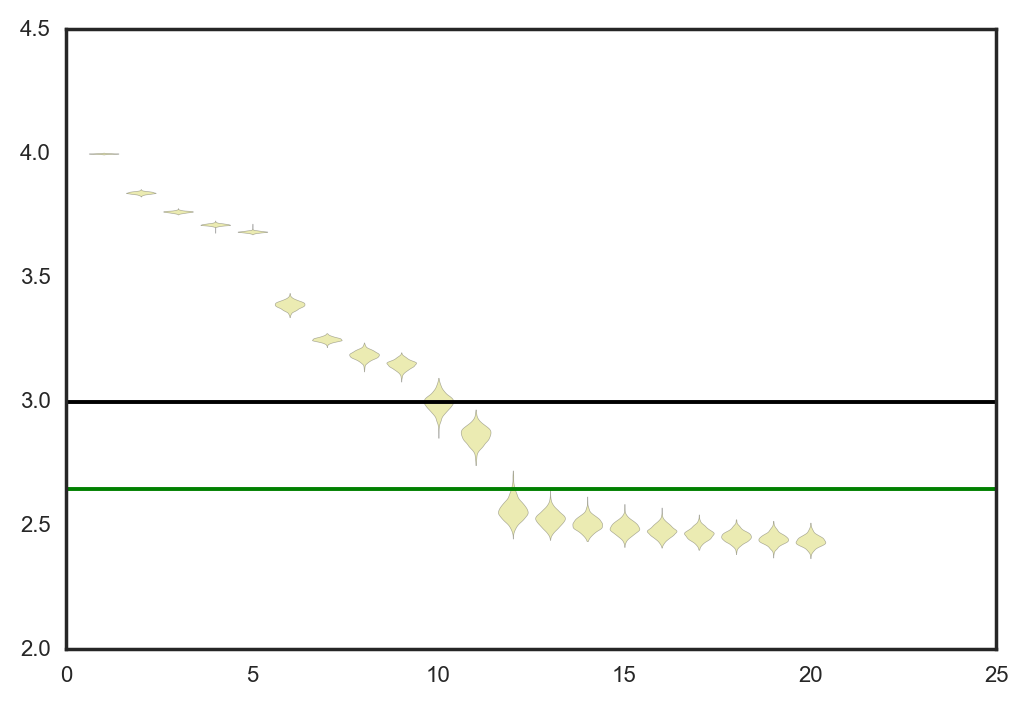

In [218]:
epsilon = 15
SV = np.array([nmr_noise(seed = i, epsilon = epsilon, m = None) for i in range(1000)])
fig, ax = plt.subplots()
violin = ax.violinplot(np.log10(SV[:,0:20]), showextrema = False, widths = 0.8);
#ax.set_yscale('log')
bnd = hankel_gaussian_complex(256)*epsilon
ax.axhline(y = np.log10(bnd), color = 'k')
ax.axhline(y = np.log10(sv_emperical*epsilon), color = 'g')

In [52]:
np.log10(sv_emperical*epsilon)

2.6471930727101705

In [219]:

for i, path in enumerate(violin['bodies']):
    verts =  path._paths[0].vertices
    output = PGF()
    output.add('x', verts[:,0])
    output.add('y', verts[:,1])
    output.write('fig_nmr_density_%02d.dat' % i)
    np.log10(SV[:,0:20])
    extrema = PGF()
    extrema.add('x', [i+1,i+1])
    extrema.add('y', [np.log10(np.min(SV[:,i])),np.log10(np.max(SV[:,i])) ])
    extrema.write('fig_nmr_extrema_%02d.dat' % i)

# AIC

In [220]:
from hsvd import hsvd, mkV
@memory.cache
def nmr_aic(seed = 0, n = 256, m = None, epsilon = 1):
    np.random.seed(seed)
    f = np.array([-86,-70,-54,152,168,292,308,360,440,490,530])
    d = np.array([50,50,50,50,50,50,50,25,285.7,25,200])
    amp = np.array([75,150,75,150,150,150,150,150,1400,60,500])
    dt = 1/3*1e-3*(n/256)
    om = (2j * np.pi * f - d)*dt
    th = 135.
    a = amp*np.exp(1j*th*np.pi/180)
    # Construct the signal
    y = np.dot(mkV(om, n),a)
    #y = np.array([a_ * np.exp(np.arange(0,256)*om_) for om_, a_ in zip(om, a)]).sum(axis = 0)
    g = (np.random.randn(n) + 1j*np.random.randn(n))/np.sqrt(2)
    yt = y + epsilon * g
    
    # Compute the optimal fit for each size problem
    aic = np.zeros(20)
    for rank in range(1,20):
        omega, a = hsvd(yt, rank)
        y_fit = np.dot(mkV(omega, n), a)
        log_likelihood = (-n/2)*np.log(2*np.pi*epsilon**2)  - np.linalg.norm(yt - y_fit)**2/(2.*epsilon**2)
        k = 4*rank
        aic[rank] = 2*k - 2*log_likelihood # + 2*k*(k+1)/(n-k-1)
    return aic
AIC = np.array([nmr_aic(seed = i, epsilon = epsilon, m = None) for i in range(1000)])

In [243]:
dat = PGF()
rank = np.arange(1,21)
dat.add('rank', rank)
est_rank = np.array([np.argmin(AIC_[1:])+1 for AIC_ in AIC])
est_rank_count = np.array([np.sum(est_rank==r) for r in rank])/len(est_rank)
dat.add('AIC', est_rank_count)
bnd_rank = np.array([np.sum(SV_ > bnd) for SV_ in SV])
bnd_rank_count = np.array([np.sum(bnd_rank==r) for r in rank])/len(bnd_rank)
dat.add('bound', bnd_rank_count)
emp_rank = np.array([np.sum(SV_ > sv_emperical*epsilon) for SV_ in SV])
emp_rank_count = np.array([np.sum(emp_rank == r) for r in rank])/len(emp_rank)
dat.add('empirical', emp_rank_count)
dat.write('fig_nmr_count.dat')

In [244]:
est_rank_count

array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.931,  0.061,  0.006,  0.001,  0.001,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ])

(array([ 968.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   32.]),
 array([ 11. ,  11.1,  11.2,  11.3,  11.4,  11.5,  11.6,  11.7,  11.8,
         11.9,  12. ]),
 <a list of 10 Patch objects>)

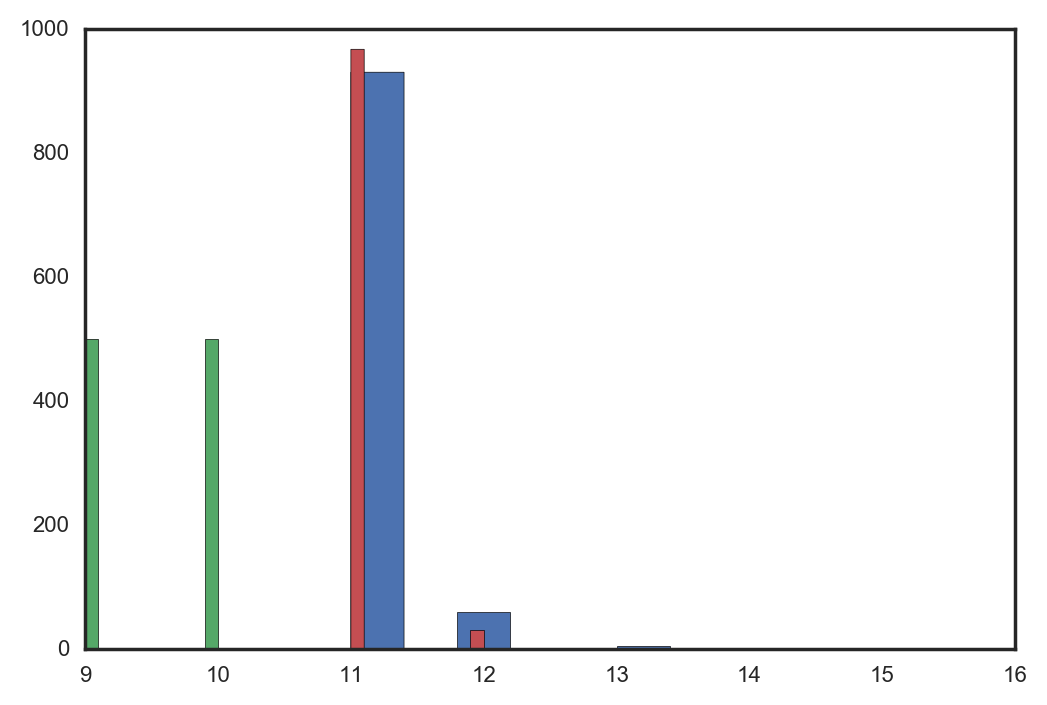

In [237]:

fig, ax = plt.subplots()
ax.hist(est_rank)
ax.hist(bnd_rank)
ax.hist(emp_rank)

In [235]:
bnd_rank

array([ 9, 10, 10,  9,  9, 10,  9, 10,  9,  9, 10,  9,  9, 10,  9, 10,  9,
        9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  9, 10, 10, 10,  9,
       10,  9, 10, 10, 10, 10,  9, 10,  9,  9,  9,  9, 10,  9, 10, 10, 10,
       10,  9,  9, 10, 10, 10, 10,  9,  9,  9,  9, 10,  9,  9,  9,  9, 10,
       10,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10,  9, 10,  9,  9, 10,  9,
        9, 10,  9,  9, 10,  9,  9, 10, 10, 10,  9,  9,  9,  9,  9, 10,  9,
       10,  9, 10,  9, 10, 10,  9,  9,  9, 10, 10,  9,  9,  9,  9,  9, 10,
        9,  9, 10,  9,  9,  9, 10,  9, 10, 10, 10,  9,  9,  9, 10,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10,  9,  9,
       10,  9, 10,  9, 10,  9, 10,  9,  9, 10, 10, 10, 10, 10, 10,  9, 10,
       10, 10, 10, 10,  9, 10, 10, 10, 10, 10,  9, 10,  9, 10, 10, 10,  9,
       10, 10, 10, 10,  9, 10,  9, 10,  9, 10, 10, 10,  9,  9, 10, 10,  9,
       10, 10, 10, 10,  9, 10,  9, 10, 10,  9, 10,  9,  9, 10, 10,  9, 10,
       10,  9,  9, 10,  9

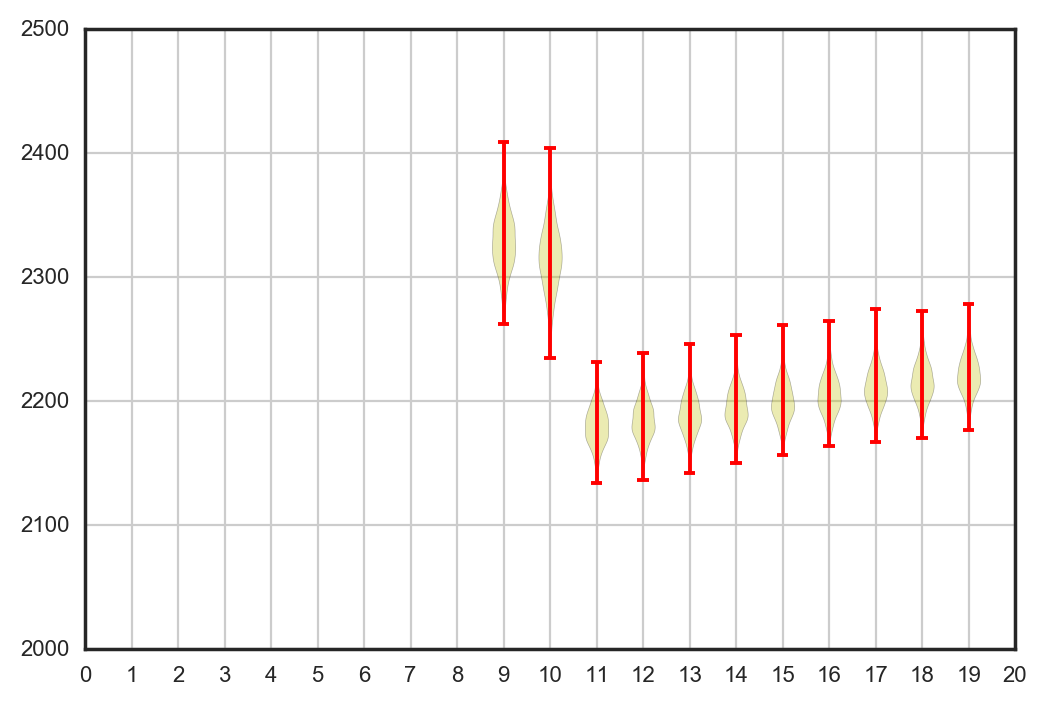

In [221]:
fig, ax = plt.subplots()
ax.violinplot(AIC[:,1:])
#ax.set_yscale('log')
ax.set_xticks(np.arange(21))
ax.set_ylim(2000,2500)
ax.grid()

In [159]:
omega = np.array([-1,-2j])
a = np.array([1,1])
y = np.dot(mkV(omega, 100),a)
#y = np.random.randn(10)
hsvd(y, 2)

(array([ -7.07767178e-16 -2.00000000e+00j,  -1.00000000e+00 -4.97739677e-16j]),
 array([ 1. +2.05994943e-14j,  1. -7.38298311e-15j]))

In [136]:
y

array([ 2.00000000+0.j        ,  1.13711834+0.63896128j,
        0.31879226+0.98302774j, -0.43720735+0.87340508j,
       -0.91437144+0.36068659j, -0.94118600-0.31849677j,
       -0.52319412-0.8506868j ,  0.14009978-0.99026599j,
        0.74014583-0.67281544j,  0.99911734-0.04484564j,
        0.79716502+0.60382143j,  0.22737361+0.9738115j ,
       -0.44732992+0.89436595j, -0.91557125+0.40215066j,
       -0.96125263-0.27566608j, -0.56329329-0.82625681j,
        0.09463887-0.99551168j,  0.70889327-0.70531581j,
        0.99597775-0.08960104j,  0.82339642+0.5674666j ,
        0.27079937+0.96263581j, -0.40677760+0.91352722j,
       -0.89661767+0.44280554j, -0.97264879-0.23228072j,
       -0.59978090-0.80016428j,  0.04989919-0.99875426j,
        0.67654969-0.73639698j,  0.99095750-0.13417615j,
        0.84801642+0.52996995j,  0.31369694+0.94952316j,
       -0.36540064+0.93085035j, -0.87585771+0.48256944j,
       -0.98208701-0.18842798j, -0.63506135-0.7724617j ,
        0.00505922-0.9999872j ,